# Create one common dataset for footprint, EC, biomet, WTD and continuous soil T and moisture data

09/2023

In [5]:
import pandas as pd
from dotenv import load_dotenv; load_dotenv()
from datetime import datetime, timedelta
import os

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import xarray as xr

from utils import load_Ran_ec_data, load_Ran_biomet_data

sns.set_context('notebook', font_scale=1.5)

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load EC and biomet flux array

In [2]:
SOILCLASSIFICATION_DATA = os.getenv('SOILCLASSIFICATION_DATA')
ONEDRIVE_FOLDER = os.getenv('ONEDRIVE_FOLDER')

In [3]:
biomet = load_Ran_biomet_data(ONEDRIVE_FOLDER, [2021, 2022])

/Users/opa/Ranskalankorpi_CC_EC/utils.py:49: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataframes.append(pd.read_csv(path(years[0]), skiprows=[1], index_col=0, date_parser=lambda x: pd.to_datetime(x)))
/Users/opa/Ranskalankorpi_CC_EC/utils.py:52: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataframes.append(pd.read_csv(path(year), skiprows=[1], index_col=0, date_parser=lambda x: pd.to_datetime(x)))


In [6]:
ec = load_Ran_ec_data(ONEDRIVE_FOLDER, [2021, 2022])
tt = ec.time.values
# remove dim_0 and set previous time values to time coordinates
ec = ec.drop_dims('dim_0').assign_coords(time=tt)

OSError: [Errno -51] NetCDF: Unknown file format: '/Users/opa/Library/CloudStorage/OneDrive-Valtion/Ranskalankorpi_clearcut_data_shared/EC/EC_flux_L2_final_FI-Ran_2021.nc'

### Get common index for EC and biomet

In [5]:
ec_time = ec.time.to_dataframe()

In [6]:
biomet_time = biomet.time.to_dataframe()

In [7]:
ind_biomet_in_ec = biomet_time.index.get_indexer(ec_time.index, method='nearest')

In [8]:
biomet_with_ec_index = biomet.isel(time=ind_biomet_in_ec)

In [9]:
biomet_with_ec_index.time.values

array(['2021-11-24T13:30:00.000000000', '2021-11-24T14:00:00.000000000',
       '2021-11-24T14:30:00.000000000', ...,
       '2022-12-31T22:30:00.000000000', '2022-12-31T23:00:00.000000000',
       '2022-12-31T23:30:00.000000000'], dtype='datetime64[ns]')

In [10]:
biomet_with_ec_index = biomet_with_ec_index.assign_coords(time=ec.time)

In [11]:
biomet_ec = xr.merge((ec, biomet_with_ec_index))

## Load fpr contribution array

In [12]:
fpr_cont = xr.open_dataset('data/footprint/footprint_soilclass_contribution_2021_2022.nc')

In [13]:
fpr_cont

<xarray.Dataset>
Dimensions:           (soil_class: 10, time: 18835)
Coordinates:
  * soil_class        (soil_class) object 'Fallen tree' ... 'Instruments'
  * time              (time) datetime64[ns] 2021-11-24T13:30:00 ... 2022-12-3...
Data variables:
    fpr_contribution  (soil_class, time) float64 ...
Attributes:
    description:  soil class contribution to footprint

In [14]:
fpr_with_ec_index = fpr_cont.assign_coords(time=ec.time)

In [15]:
biomet_ec_fpr = xr.merge((biomet_ec, fpr_with_ec_index))

In [16]:
datetime(2020,1,1) + timedelta(hours=16, minutes=30)

datetime.datetime(2020, 1, 1, 16, 30)

## WTD

In [17]:
def date_parser_wtd(row):
    # There are four types of string that can come from row. This need to handled separately
    # The idea is to first parse only the date from both options (first 10 characters) and then extract the time of day separately
    # For each case that was found
    # First one is 2020-06-02 00:00:00 20:00:00
    # The second one is e.g., 2020-07-05 00:00:00 1900-02-02 18:00:00
    # The third is 2020-07-05 00:00:00 1900-02-02 18:00:00.59.590000
    # the fouth is 2020-07-05 00:00:00 1900-02-02 24:00:00

    # Take date
    date = datetime.strptime(row[:10], r'%Y-%m-%d')

    # check if there is . in the time

    if "." in row:
        t = row[20:28]
    else:
        t = row[-8:]
    
    t_split = t.split(":")
    hours = int(t_split[0])
    minutes = int(t_split[1])

    if hours == 0 and minutes == 0:
        hours = 24
        minutes = 0

    date = date + timedelta(hours=hours, minutes=minutes)

    return date

In [18]:
wtd = pd.read_excel(f'{ONEDRIVE_FOLDER}/WTD/ranskalankorpi_odyssey_data/Odyssey_wt-data_ranskalankorpi_2020-05-12_2023-04-27.xlsx', skiprows=4, header=0, parse_dates={'datetime': ['Date','Time']}, date_parser= lambda x: date_parser_wtd(x), index_col='datetime')

/var/folders/_7/7fgf24sd5ggbyr5x9kzrwz7c0000gn/T/ipykernel_2949/1193253790.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  wtd = pd.read_excel(f'{ONEDRIVE_FOLDER}/WTD/ranskalankorpi_odyssey_data/Odyssey_wt-data_ranskalankorpi_2020-05-12_2023-04-27.xlsx', skiprows=4, header=0, parse_dates={'datetime': ['Date','Time']}, date_parser= lambda x: date_parser_wtd(x), index_col='datetime')


In [19]:
wtd.index.unique()

DatetimeIndex(['2020-05-12 15:00:00', '2020-05-12 15:30:00',
               '2020-05-12 16:00:00', '2020-05-12 16:30:00',
               '2020-05-12 17:00:00', '2020-05-12 17:30:00',
               '2020-05-12 18:00:00', '2020-05-12 18:30:00',
               '2020-05-12 19:00:00', '2020-05-12 19:30:00',
               ...
               '2023-04-27 06:00:00', '2023-04-27 07:00:00',
               '2023-04-27 08:00:00', '2023-04-27 09:00:00',
               '2023-04-27 10:00:00', '2023-04-27 11:00:00',
               '2023-04-27 12:00:00', '2023-04-27 13:00:00',
               '2023-04-27 14:00:00', '2023-04-27 15:00:00'],
              dtype='datetime64[ns]', name='datetime', length=43368, freq=None)

In [20]:
ec_time.index.unique().shape

(18835,)

In [21]:
ec_time.shape

(18835, 1)

In [22]:
np.diff(wtd.index).astype(np.float64)

array([1.8e+12, 1.8e+12, 1.8e+12, ..., 3.6e+12, 3.6e+12, 3.6e+12])

In [23]:
wtd_ind_in_ec = wtd.index.get_indexer(ec_time.index, method='nearest')

In [24]:
wtd_data = wtd.iloc[wtd_ind_in_ec].loc[:, 'block6']

### Interpolate WTD data. Note that this means that starting 29.7.2022 the data is the same number -32.1

In [25]:
wtd_data = wtd_data.interpolate()
wtd_data[0] = wtd_data[1]

/var/folders/_7/7fgf24sd5ggbyr5x9kzrwz7c0000gn/T/ipykernel_2949/287283201.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wtd_data[0] = wtd_data[1]
/var/folders/_7/7fgf24sd5ggbyr5x9kzrwz7c0000gn/T/ipykernel_2949/287283201.py:2: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  wtd_data[0] = wtd_data[1]


In [26]:
biomet_ec_fpr_wtd = biomet_ec_fpr.assign(wtd_odyssey_block6=(["time"], wtd_data.to_numpy(), {'description':  'WTD from block6 odyssey logger (cm below soil surface)', 'unit': 'cm'}))

In [27]:
biomet_ec_fpr_wtd.TA_1_1_1.interpolate_na(dim='time', method='linear', fill_value='extrapolate')

<xarray.DataArray 'TA_1_1_1' (time: 18835)>
array([-0.5147, -0.9982, -1.0655, ..., -5.5636, -5.6094, -5.6552])
Coordinates:
  * time     (time) datetime64[ns] 2021-11-24T13:30:00 ... 2022-12-31T23:30:0...

In [28]:
wtd = wtd.rename(columns={'Unnamed: 14': 'block3','cc_ac': 'automatic chambers'})

In [29]:
wtd = wtd.assign(block6_interpolate = wtd.block6.interpolate().to_numpy())

In [30]:
wtd.columns

Index(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6',
       'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'block3', 'automatic chambers', 'block6',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'block6_interpolate'],
      dtype='object')

Text(0, 0.5, 'WTD (cm)')

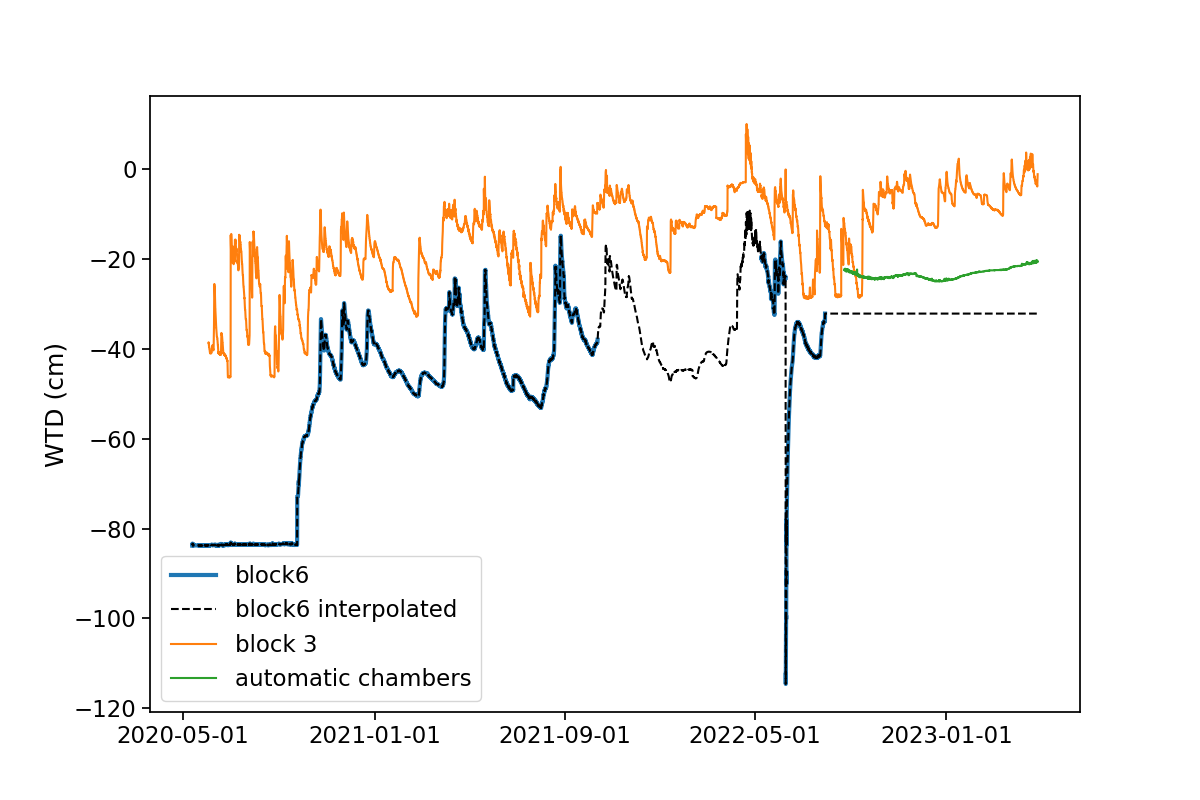

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ax.plot(wtd.index, wtd.block6, label='block6', linewidth=3)
ax.plot(wtd.index, wtd.block6_interpolate, label='block6 interpolated', color='k', linestyle='--')
ax.plot(wtd.index, wtd.block3, label='block 3')
ax.plot(wtd.index, wtd.loc[:, 'automatic chambers'], label='automatic chambers')
ax.legend()

ticks = ax.get_xticks()

ax.set_xticks(ticks[::2])
ax.set_ylabel('WTD (cm)')
#wtd.loc[:, ['block6', 'block6_interpolate', 'block3','automatic chambers']].plot()

## Continuous soil T and moisture

In [32]:
wtd_helena = pd.read_excel(f'{ONEDRIVE_FOLDER}/continuous_soil_T_moisture/cc_site_environmental_data_Helena.xlsx', header=0, index_col='datetime')

In [33]:
wtd_helena_ind_in_ec = wtd_helena.index.get_indexer(ec_time.index, method='nearest')

In [34]:
soil_moisture = wtd_helena.iloc[wtd_helena_ind_in_ec, :]

In [35]:
soil_moisture.head()

,T5_cc,sm5_cc,wtl_block3_cc,wtl_block6_cc,precipitation_mm
datetime,,,,,
2021-11-24 13:30:00,0.007037,0.32,-7.275,-27.99375,0.0
2021-11-24 14:00:00,0.000296,0.32,-7.300,-28.05000,0.0
2021-11-24 14:30:00,-0.006519,0.32,-7.325,-28.10625,0.0
2021-11-24 15:00:00,-0.011463,0.32,-7.350,-28.16250,0.0
2021-11-24 15:30:00,-0.016296,0.32,-7.375,-28.21875,0.0


In [36]:
biomet_ec_fpr_wtd = biomet_ec_fpr_wtd.assign(wtd_helena_block3=(["time"], soil_moisture.wtl_block3_cc.to_numpy(), {'description':  'WTD from block 3 odyssey loggers from Helena Rautakoski', 'unit': 'cm'}))
biomet_ec_fpr_wtd = biomet_ec_fpr_wtd.assign(wtd_helena_block6=(["time"], soil_moisture.wtl_block6_cc.to_numpy(), {'description':  'WTD from block 6 odyssey loggers from Helena Rautakoski', 'unit': 'cm'}))
biomet_ec_fpr_wtd = biomet_ec_fpr_wtd.assign(T_soil_ac=(["time"], soil_moisture.T5_cc.to_numpy(), {'description':  'Soil temperature at 5 cm below surface from automated chambers', 'unit': 'C'}))
biomet_ec_fpr_wtd = biomet_ec_fpr_wtd.assign(soil_moisture_ac=(["time"], soil_moisture.sm5_cc.to_numpy(), {'description':  'Soil moisture at 5 cm below surface from automated chambers', 'unit': 'm3m-3'}))
biomet_ec_fpr_wtd = biomet_ec_fpr_wtd.assign(precipitation=(["time"], soil_moisture.precipitation_mm.to_numpy(), {'description':  'Precipitation from tower at clearcut site', 'unit': 'mm'}))

## TOMST soil T and moisture

In [37]:
def tomst_date_parser(x):
    # Date in tomst format is
    # 2021-10-01T00:00:00Z
    date = datetime.strptime(x, r'%Y-%m-%dT%H:%M:%SZ')

    return date

In [38]:
wtd = pd.read_excel(f'{ONEDRIVE_FOLDER}/WTD/ranskalankorpi_odyssey_data/Odyssey_wt-data_ranskalankorpi_2020-05-12_2023-04-27.xlsx', skiprows=4, header=0, parse_dates={'datetime': ['Date','Time']}, date_parser= lambda x: date_parser_wtd(x), index_col='datetime')

/var/folders/_7/7fgf24sd5ggbyr5x9kzrwz7c0000gn/T/ipykernel_2949/1193253790.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  wtd = pd.read_excel(f'{ONEDRIVE_FOLDER}/WTD/ranskalankorpi_odyssey_data/Odyssey_wt-data_ranskalankorpi_2020-05-12_2023-04-27.xlsx', skiprows=4, header=0, parse_dates={'datetime': ['Date','Time']}, date_parser= lambda x: date_parser_wtd(x), index_col='datetime')


In [39]:
tomst = pd.read_csv(f'{ONEDRIVE_FOLDER}/continuous_soil_T_moisture/aggregateData_30min.csv', parse_dates = {'datetime': ['time_30min']}, date_parser=lambda x: tomst_date_parser(x), index_col='datetime')

/var/folders/_7/7fgf24sd5ggbyr5x9kzrwz7c0000gn/T/ipykernel_2949/4169120506.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  tomst = pd.read_csv(f'{ONEDRIVE_FOLDER}/continuous_soil_T_moisture/aggregateData_30min.csv', parse_dates = {'datetime': ['time_30min']}, date_parser=lambda x: tomst_date_parser(x), index_col='datetime')


In [40]:
tomst = tomst.query('Canopy_treatment == "clearcut" and Disturbance_treatment == "Control"')

In [41]:
tomst['Plot'] = tomst['Plot'].astype(np.int32)

In [42]:
tomst.head()

,date,Plot,Canopy_treatment,Disturbance_treatment,T1_soil,T2_surface,T3_air,moist
datetime,,,,,,,,
2021-10-01 00:00:00,2021-10-01,2,clearcut,Control,7.94,6.12,5.88,55.40
2021-10-01 00:30:00,2021-10-01,2,clearcut,Control,7.91,5.84,5.34,55.40
2021-10-01 01:00:00,2021-10-01,2,clearcut,Control,7.88,4.81,3.53,55.40
2021-10-01 01:30:00,2021-10-01,2,clearcut,Control,7.88,4.00,2.62,55.40
2021-10-01 02:00:00,2021-10-01,2,clearcut,Control,7.84,3.81,2.91,55.45


In [43]:
tomst.Plot.unique()

array([2, 3, 4], dtype=int32)

### Loop through the plots and add to dataframe

In [44]:
for plot in tomst.Plot.unique():
    tomst_temp = tomst.query(f'Plot == {plot}')
    tomst_temp = tomst_temp.assign(row_number = np.arange(tomst_temp.shape[0]))
    tomst_temp = tomst_temp.loc[tomst_temp.row_number % 49 != 0]
    ind = tomst_temp.index.get_indexer(ec_time.index, method='nearest')
    tomst_temp = tomst_temp.iloc[ind, :].loc[:, ['T1_soil','T2_surface','T3_air','moist']]
    tomst_temp = tomst_temp.rename(columns={'T1_soil':'T_soil_tomst', 'T2_surface':'T_surface_tomst','T3_air': 'T_air_tomst', 'moist': 'soil_moisture_tomst'})

    start_desc = ['Soil temperature at 6 cm below surface Tomst','Surface temperature Tomst','Air temperature Tomst','Soil moisture Tomst']
    units = ['C','C','C','cm m-1']

    for i,column in enumerate(tomst_temp.columns):
        # name the new dataarray
        data_name = f'{column}_plot_{plot}'
        desc_temp = start_desc[i] + f' plot {plot}' 
        biomet_ec_fpr_wtd[data_name] = (['time'], tomst_temp.loc[:, column].to_numpy(), {'Description': desc_temp, 'unit': units[i]})


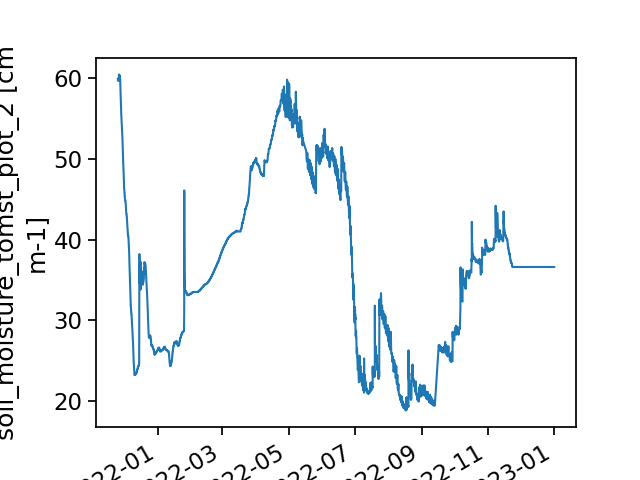

In [45]:
fig, ax = plt.subplots()
fig.subplots_adjust(left=0.15)
biomet_ec_fpr_wtd.soil_moisture_tomst_plot_2.plot(ax=ax)


In [46]:
biomet_ec_fpr_wtd.time

<xarray.DataArray 'time' (time: 18835)>
array(['2021-11-24T13:30:00.000000000', '2021-11-24T13:59:59.999999893',
       '2021-11-24T14:30:00.000000106', ..., '2022-12-31T22:30:00.000000000',
       '2022-12-31T22:59:59.999999893', '2022-12-31T23:30:00.000000106'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-11-24T13:30:00 ... 2022-12-31T23:30:0...

## Save the created array

In [47]:
#biomet_ec_fpr_wtd.to_netcdf(f'{ONEDRIVE_FOLDER}/ec_biomet_wtd_2021_2022_footprints_nan.nc', format='NETCDF4')